# Introduction to Survival Support Vector Machine

This guide demonstrates how to use the efficient implementation of *Survival Support Vector Machines*, which is an extension of the standard [Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine) to right-censored time-to-event data. Its main advantage is that it can account for complex, non-linear relationships between features and survival via the so-called kernel trick. A kernel function implicitly maps the input features into high-dimensional feature spaces where survival can be described by a hyperplane. This makes Survival Support Vector Machines extremely versatile and applicable to a wide a range of data. A popular example for such a kernel function is the [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).

Survival analysis in the context of Support Vector Machines can be described in two different ways:

1. As a **ranking** problem: the model learns to assign samples with shorter survival times a lower *rank* by considering all possible pairs of samples in the training data.
2. As a **regression** problem: the model learns to directly predict the (log) survival time.

In both cases, the disadvantage is that predictions cannot be easily related to standard quantities in survival analysis, namely survival function and cumulative hazard function. Moreover, they have to retain a copy of the training data to do predictions.

Let's start by taking a closer look at the Linear Survival Support Vector Machine, which does not allow selecting a specific kernel function, but can be fitted faster than the more generic Kernel Survival Support Vector Machine.


## Linear Survival Support Vector Machine

The class [sksurv.svm.FastSurvivalSVM](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.svm.FastSurvivalSVM.html#sksurv.svm.FastSurvivalSVM) is used to train
a linear Survival Support Vector Machine. Training data consists of $n$ triplets $(\mathbf{x}_i, y_i, \delta_i)$, where
$\mathbf{x}_i$ is a $d$-dimensional feature vector, $y_i > 0$ the survival time or time of censoring, and $\delta_i \in \{0,1\}$ the binary event indicator. Using the training data, the objective is to minimize the following function:

\begin{equation}
\arg \min_{\mathbf{w}, b} \frac{1}{2} \mathbf{w}^T \mathbf{w}+ \frac{\alpha}{2} \left[
r \sum_{i,j \in \mathcal{P}}
\max(0, 1 - (\mathbf{w}^T \mathbf{x}_i - \mathbf{w}^T \mathbf{x}_j))^2
+ (1 - r) \sum_{i=0}^n \left( \zeta_{\mathbf{w},b} (y_i, x_i, \delta_i) \right)^2
\right]
\end{equation}

\begin{equation}
\zeta_{\mathbf{w},b} (y_i, \mathbf{x}_i, \delta_i) =
\begin{cases}
\max(0, y_i - \mathbf{w}^T \mathbf{x}_i - b) & \text{if $\delta_i = 0$,}\\
y_i - \mathbf{w}^T \mathbf{x}_i - b & \text{if $\delta_i = 1$,}\\
\end{cases}
\end{equation}

\begin{equation}
\mathcal{P} = \{ (i, j)~|~y_i > y_j \land \delta_j = 1 \}_{i,j=1,\dots,n}
\end{equation}

The hyper-parameter $\alpha > 0$ determines the amount of regularization to apply: a smaller value increases the amount of regularization and a higher value reduces the amount of regularization. The hyper-parameter $r \in [0; 1]$ determines the trade-off between the ranking objective and the regression objective. If $r = 1$ it reduces to the ranking objective, and if $r = 0$ to the regression objective. If the regression objective is used, it is advised to log-transform the observed time first.

The class [sksurv.svm.FastSurvivalSVM](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.svm.FastSurvivalSVM.html#sksurv.svm.FastSurvivalSVM) adheres to interfaces used in [scikit-learn](https://scikit-learn.org) and thus it is possible to combine it with auxiliary classes and functions from scikit-learn. In this example, we are going to use the ranking objective ($r = 1$) and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to determine the best setting for the hyper-parameter $\alpha$ on the Veteran's Lung Cancer data. 

First, we have to import the classes we are going to use.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

Next, we load data of the *Veteran's Administration Lung Cancer Trial* from disk and convert it to numeric values. The data consists of 137 patients and 6 features. The primary outcome measure is death (`Status`, `Survival_in_days`).
The original data can be retrieved from http://lib.stat.cmu.edu/datasets/veteran.

In [2]:
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

`data_x` is a data frame containing the features, and `y` is a structured array containing the event indicator $\delta_i$, as boolean, and the survival/censoring time $y_i$ for training.

Now, we are essentially ready to start training, but before let's determine what the amount of censoring for this data is and plot the survival/censoring times.

In [3]:
n_censored = y.shape[0] - y["Status"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

6.6% of records are censored


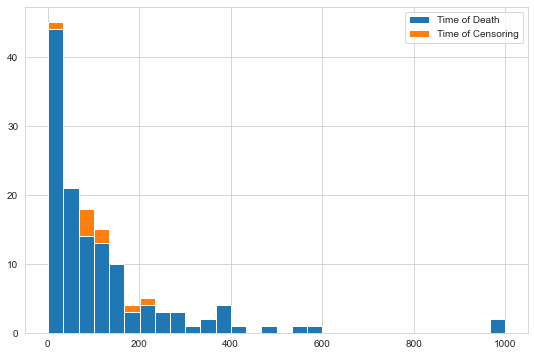

In [4]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y["Survival_in_days"][y["Status"]],
                               y["Survival_in_days"][~y["Status"]]),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

First, we need to create an initial model with default parameters that is subsequently used in the grid search.

In [5]:
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

Next, we define a function for evaluating the performance of models during grid search. We use Harrell's concordance index.

In [6]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]

The last part of the setup specifies the set of parameters we want to try and how many repetitions of training and testing we want to perform for each parameter setting. In the end, the parameters that on average performed best across all test sets (100 in this case) are selected. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) can leverage multiple cores by evaluating multiple parameter settings concurrently (4 jobs in this example).

In [7]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=4, refit=False,
                   cv=cv)

Finally, start the hyper-parameter search. This can take a while since a total of ``13 * 100 = 1300`` fits have to be evaluated.

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
gcv = gcv.fit(x, y)

Let's check what is the best average performance across 100 random train/test splits we got and the corresponding hyper-parameters.

In [9]:
round(gcv.best_score_, 3), gcv.best_params_

(0.72, {'alpha': 0.00390625})

Finally, we retrieve all 100 test scores for each parameter setting and visualize their distribution by box plots.

In [10]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):            
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

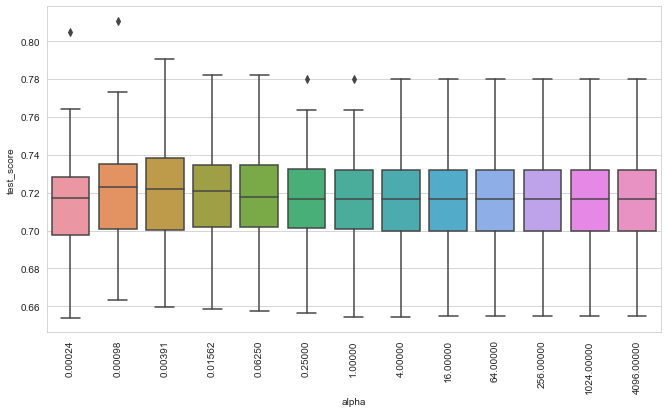

In [11]:
plot_performance(gcv)

We can observe that the model seems to be relative robust with respect to the choice for $\alpha$ for this dataset. Let's fit a model using the $\alpha$ value that performed best.

In [12]:
estimator.set_params(**gcv.best_params_)
estimator.fit(x, y)

FastSurvivalSVM(alpha=0.00390625, max_iter=1000, optimizer='avltree',
                random_state=0, tol=1e-05)

It is important to remember that only if the ranking objective is used exclusively ($r = 1$),
that predictions denote risk scores, i.e. a higher predicted value indicates shorter survival,
a lower value longer survival.

In [13]:
pred = estimator.predict(x.iloc[:2])
print(np.round(pred, 3))
print(y[:2])

[-1.59  -1.687]
[( True,  72.) ( True, 411.)]


The model predicted that the first sample has a lower risk than the second sample, which is in concordance with the actual survival times.

### Regression Objective

If the regression objective is used ($r < 1$), the semantics are different, because now predictions are on the time scale and lower predicted values indicate shorter survival, higher values longer survival.
Moreover, we saw from the histogram of observed times above that the distribution is skewed, therefore
it is advised to log-transform the observed time before fitting a model. Here, we are going to use the transformation $y^\prime = \log(1 + y)$.

In [14]:
y_log_t = y.copy()
y_log_t["Survival_in_days"] = np.log1p(y["Survival_in_days"])

Let's fit a model using the regression objective ($r = 0$) and compare its performance to the ranking model from above.

In [15]:
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(x, y_log_t)

cindex = concordance_index_censored(
    y['Status'],
    y['Survival_in_days'],
    -ref_estimator.predict(x),  # flip sign to obtain risk scores
)
print(round(cindex[0], 3))

0.724


Note that `concordance_index_censored` expects risk scores, therefore, we had to flip the sign of predictions.
The resulting performance of the regression model is comparable to the of the ranking model above.

Finally, when predicting survival time, we need to invert the log-transformation via $y = \exp(y^\prime) - 1$.

In [16]:
pred_log = ref_estimator.predict(x.iloc[:2])
pred_y = np.expm1(pred_log)
print(np.round(pred_y, 3))

[106.683 131.105]


## Kernel Survival Support Vector Machine

The *Kernel Survival Support Vector Machine* is a generalization of the *Linear Survival Support Vector Machine* that can account for more complex relationships between features and survival time, it is implemented in [sksurv.svm.FastKernelSurvivalSVM](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.svm.FastKernelSurvivalSVM.html#sksurv.svm.FastKernelSurvivalSVM). The disadvantage is that the choice of kernel function and its hyper-parameters is often not straightforward and requires tuning to obtain good results. For instance, the [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) has a hyper-parameter $\gamma$ that needs to be set: $k(x, x^\prime) = \exp(-\gamma \|x-x^\prime \|^2)$. There are many other [built-in kernel functions](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html#sklearn.metrics.pairwise.pairwise_kernels) that can be used by passing their name as `kernel` parameter to `FastKernelSurvivalSVM`.

In this example, we are going to use the clinical kernel, because it is able to distinguish between continuous, ordinal, and nominal attributes. As this is a custom kernel function, we first need to pre-compute the kernel matrix.

In [17]:
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM

In [18]:
kernel_matrix = clinical_kernel(data_x)

As with the *Linear Survival Support Vector Machine* above, we are going to determine the optimal $\alpha$ value  by using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [19]:
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model,
                    n_jobs=4, refit=False,
                    cv=cv)

Note that when using a custom kernel, we do not pass the original data (`data_x`) to the fit function, but the pre-computed, square kernel matrix.

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
kgcv = kgcv.fit(kernel_matrix, y)

Now, print the best average concordance index and the corresponding parameters.

In [21]:
round(kgcv.best_score_, 3), kgcv.best_params_

(0.709, {'alpha': 0.015625})

Finally, we visualize the distribution of test scores obtained via cross-validation.

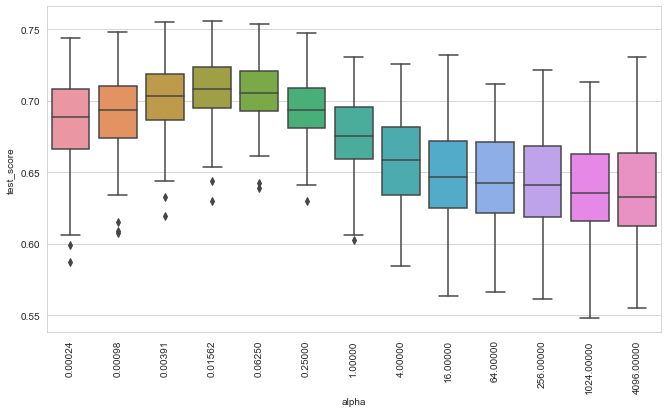

In [22]:
plot_performance(kgcv)

We can see that the choice of $\alpha$ is much more important here, compared to the Linear Survival Support Vector Machine. Nevertheless, the best performance is below that of the linear model, which illustrates that choosing a good kernel function is essential, but also a non-trivial task.

## References

> Pölsterl, S., Navab, N., and Katouzian, A.,
> *Fast Training of Support Vector Machines for Survival Analysis*,
> Machine Learning and Knowledge Discovery in Databases: European Conference,
> ECML PKDD 2015, Porto, Portugal,
> Lecture Notes in Computer Science, vol. 9285, pp. 243-259 (2015)

> Pölsterl, S., Navab, N., and Katouzian, A.,
> *An Efficient Training Algorithm for Kernel Survival Support Vector Machines*
> 4th Workshop on Machine Learning in Life Sciences,
> 23 September 2016, Riva del Garda, Italy